# **Ouroboros EEG-fMRI: Predicting EEG activity from fMRI activity and vice versa**

#### Version: 22nd August 2022

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through five Notebooks:

*01: Data Analysis*

***02: Classification***

*03: Regression on fMRI data*

*04: Regression on EEG data*

*05: Results*

==============================================================================================

### Notebook 02

# **Classification**

## **1. Introduction to Classification**

### 1.1 Objective

The objective of this project is to address the general question: **Can we train machine learning models to predict EEG activity from fMRI activity, and vice versa?** In this Notebook, as a preliminary step, we will evaluate whether our EEG and fMRI datasets can be used to predict another type of information, the hypnogram. 

A hypnogram is a graph representing the succession of the stages of sleep. These stages include the **REM (Rapid Eye Movement) sleep**, and three stages of **NREM (Non Rapid Eye Movement) sleep**, defined as NREM 1, 2, 3. The article indicates that the hypnogram was established for each subject by two expert sleep scorers, according to AASM criteria. We can expect to see a strong link between our EEG dataset and the hypnogram data, since the EEG data was most probably used to define the stages of sleep (see for example: https://jcsm.aasm.org/doi/10.5664/jcsm.3880). More generally, the stages of wakefulness and sleep have a strong impact on the brain activity, and we should be able to train machine learning models to classify these stages using both EEG and fMRI data as predictors. Therefore, this Notebook will serve as a first step to evaluate the accuracy of the information that we can extract from EEG and fMRI data. 

### 1.2 Models

We will use a variety of classification models: **k-NN**, **decision tree**, **random forest**, **SVM**, **logistic regression**. For all subjects, we will fine-tune the hyperparameters of these models using a grid search with cross-validation approach, and store the test score as well as the value of the best hyperparameter found. For the fMRI data, we will use the preprocessed dataset obtained after a voxel size rescaling by a factor 3, in order to avoid heavy computations. The baseline will be a model that always predicts the most frequent value from the train set. 

### 1.3 Data import

Here we import the **EEG dataset** and the **preprocessed fMRI dataset**. For the latter, we store the data in dictionaries. 

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define the preprocessed data path. 
preprocessed_data_path = '../ouroboros_eeg-fmri_preprocessed_data/'

# Define the results path. If empty, the results will be saved in the current directory. 
results_path = ''

In [3]:
# Define the list of subjects. 
subjects = []

for subject_index in range(18):
    if subject_index < 9:
        subjects.append('sub-0' + str(subject_index + 1))
    else:
        subjects.append('sub-' + str(subject_index + 1))

print(subjects)

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18']


In [4]:
# Load the EEG data. 
with open(preprocessed_data_path + 'predictors_EEG.p', 'rb') as file:
    predictors_EEG = pickle.load(file)

In [5]:
# Load the fMRI data, and store the data in dictionaries. 
predictors_fMRI = dict()
predictors_fMRI_r2 = dict()
predictors_fMRI_r3 = dict()

# Iterate through all subjects. 
counter = 1
for subject_index in subjects:
    
    # Display current step. 
    print('Starting subject ' + str(counter) + ' / ' + str(len(subjects)))
    
    # Load fMRI data with the original voxel size. 
    with np.load(preprocessed_data_path + 'predictors_fMRI.npz', allow_pickle = False) as npz_file:
        predictors_fMRI[subject_index] = npz_file['sub_' + str(counter)]
    
    # Load fMRI data with the voxel size rescaling by a factor 2. 
    with np.load(preprocessed_data_path + 'predictors_fMRI_r2.npz', allow_pickle = False) as npz_file:
        predictors_fMRI_r2[subject_index] = npz_file['sub_' + str(counter)]
        
    # Load fMRI data with the voxel size rescaling by a factor 3. 
    with np.load(preprocessed_data_path + 'predictors_fMRI_r3.npz', allow_pickle = False) as npz_file:
        predictors_fMRI_r3[subject_index] = npz_file['sub_' + str(counter)]
        
    # Increment. 
    counter += 1

Starting subject 1 / 18
Starting subject 2 / 18
Starting subject 3 / 18
Starting subject 4 / 18
Starting subject 5 / 18
Starting subject 6 / 18
Starting subject 7 / 18
Starting subject 8 / 18
Starting subject 9 / 18
Starting subject 10 / 18
Starting subject 11 / 18
Starting subject 12 / 18
Starting subject 13 / 18
Starting subject 14 / 18
Starting subject 15 / 18
Starting subject 16 / 18
Starting subject 17 / 18
Starting subject 18 / 18


In [6]:
# Determine the proportion of the test set for the classification models. 
test_set_proportion = 0.2

## **2. Hypnogram prediction based on EEG data**

### **2.1 K-Nearest Neighbors (k-NN)**

In the following cells, we **fine-tune, fit and compute predictions from a k-NN model**. 

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [8]:
# Define the set of values to explore, where k is the number of neighbors. 
k_values = np.arange(1, 10, 1)
k_values

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
# Create pipeline. 
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Create cross-validation object. 
grid_knn = {
    'knn__n_neighbors': k_values
}
grid_cv_knn = GridSearchCV(pipe_knn, grid_knn, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [10]:
# Define a function to run a classification model, taking the EEG frequency bands as features and the hypnogram as target. 
def classification_with_EEG_predictors(grid_cv, param_name):
    
    # Create a Pandas DataFrame to store the results. 
    model_results = pd.DataFrame()

    # Iterate through all subjects. 
    for subject_index in subjects:

        # Display current step. 
        print('Starting subject ' + subject_index)

        # Retrieve the predictors, taking the EEG frequency bands as features and the hypnogram as target. 
        X = predictors_EEG[subject_index].iloc[:, 2:].values
        y = predictors_EEG[subject_index].iloc[:, 1].values

        # Divide the data into a train set and a test set. 
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)

        # Create a baseline containing only the most frequent value in the train set. 
        most_frequent_value = np.bincount(y_tr.astype(int)).argmax()
        classification_baseline = np.sum(y_te.astype(int) == most_frequent_value) / y_te.shape[0]

        # Fit the model. 
        grid_cv.fit(X_tr, y_tr)

        # Compute the test score. 
        test_score = grid_cv.score(X_te, y_te)

        # Store the results in the DataFrame. 
        model_results.loc[subject_index, param_name] = grid_cv.best_params_[param_name]
        model_results.loc[subject_index, 'test score'] = test_score
        model_results.loc[subject_index, 'baseline'] = classification_baseline
        
    return model_results

In [11]:
# Run the model. 
knn_results = classification_with_EEG_predictors(grid_cv_knn, 'knn__n_neighbors')

Starting subject sub-01
Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [12]:
# Display the results. 
knn_results

,knn__n_neighbors,test score,baseline
sub-01,1.0,0.939815,0.473765
sub-02,1.0,0.980360,0.535188
sub-03,1.0,0.923077,0.313462
sub-04,1.0,0.927660,0.436170
sub-05,1.0,0.931755,0.583565
sub-06,1.0,0.915563,0.445364
sub-07,1.0,0.935484,0.607211
sub-08,1.0,0.910494,0.456790
sub-09,1.0,0.932790,0.464358
sub-10,1.0,0.934358,0.409218


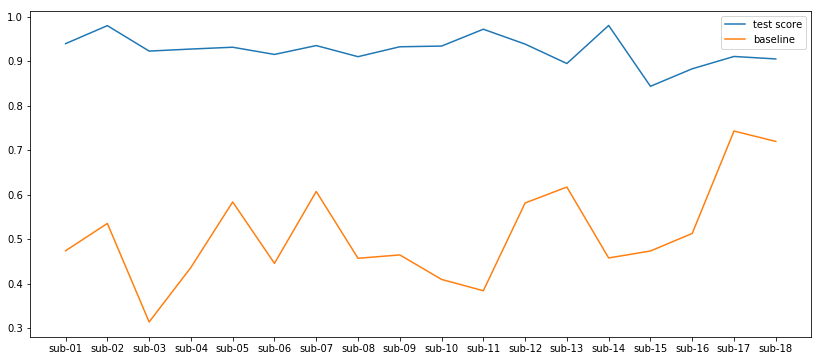

In [13]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(knn_results[['test score']], label = 'test score')
plt.plot(knn_results[['baseline']], label = 'baseline')
plt.legend();

**Result:** Overall, the k-NN model using the EEG data as predictors performs better than the baseline for our group of subjects. 

### **2.2 Decision tree**

In the following cells, we **fine-tune, fit and compute predictions from a decision tree model**. 

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
# Define the set of values to explore, where d is the depth of the tree. 
d_values = np.arange(1, 10, 1)
d_values

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [16]:
# Create pipeline. 
pipe_dt = Pipeline([
    ('scaler', None),
    ('dt', DecisionTreeClassifier(criterion = 'gini'))
])

# Create cross-validation object. 
grid_dt = {
    'dt__max_depth': d_values
}
grid_cv_dt = GridSearchCV(pipe_dt, grid_dt, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [17]:
# Run the model. 
dt_results = classification_with_EEG_predictors(grid_cv_dt, 'dt__max_depth')

Starting subject sub-01
Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [18]:
# Display the results. 
dt_results

,dt__max_depth,test score,baseline
sub-01,9.0,0.810185,0.481481
sub-02,9.0,0.890344,0.545008
sub-03,9.0,0.775000,0.328846
sub-04,9.0,0.776596,0.419149
sub-05,8.0,0.853760,0.607242
sub-06,9.0,0.832781,0.473510
sub-07,9.0,0.810247,0.584440
sub-08,9.0,0.790123,0.438272
sub-09,8.0,0.841141,0.443992
sub-10,9.0,0.833799,0.403631


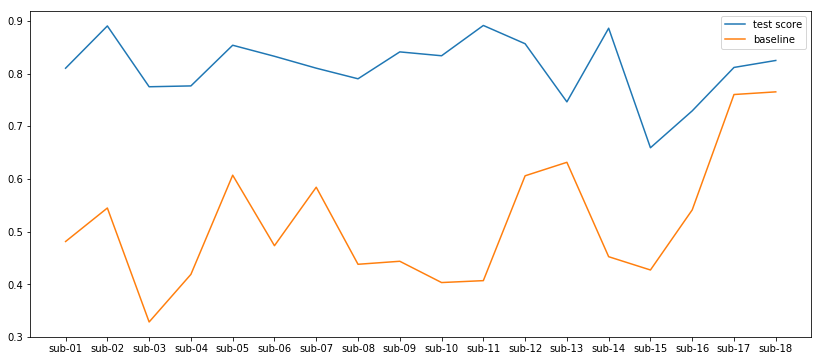

In [19]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(dt_results[['test score']], label = 'test score')
plt.plot(dt_results[['baseline']], label = 'baseline')
plt.legend();

**Result:** Overall, the decision tree model using the EEG data as predictors performs better than the baseline for our group of subjects. 

### **2.3 Random forest**

In the following cells, we **fine-tune, fit and compute predictions from a random forest model**. 

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
# Define the set of values to explore, where n is the number of trees. 
n_values = np.arange(5, 105, 5)
n_values

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100])

In [22]:
# Create pipeline. 
pipe_rf = Pipeline([
    ('scaler', None),
    ('rf', RandomForestClassifier(max_depth = None))
])

# Create cross-validation object. 
grid_rf = {
    'rf__n_estimators': n_values
}
grid_cv_rf = GridSearchCV(pipe_rf, grid_rf, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [23]:
# Run the model. 
rf_results = classification_with_EEG_predictors(grid_cv_rf, 'rf__n_estimators')

Starting subject sub-01
Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [24]:
# Display the results. 
rf_results

,rf__n_estimators,test score,baseline
sub-01,100.0,0.873457,0.475309
sub-02,90.0,0.941080,0.533552
sub-03,75.0,0.834615,0.319231
sub-04,45.0,0.848936,0.404255
sub-05,90.0,0.917827,0.580780
sub-06,70.0,0.869205,0.435430
sub-07,65.0,0.891841,0.567362
sub-08,100.0,0.907407,0.453704
sub-09,80.0,0.898167,0.462322
sub-10,85.0,0.877095,0.412011


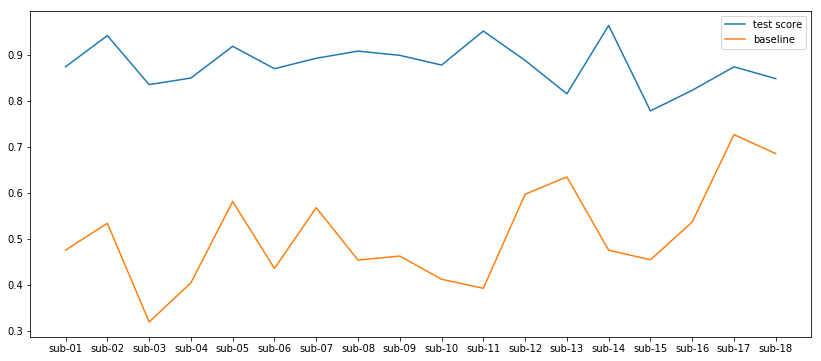

In [25]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(rf_results[['test score']], label = 'test score')
plt.plot(rf_results[['baseline']], label = 'baseline')
plt.legend();

**Result:** Overall, the random forest model using the EEG data as predictors performs better than the baseline for our group of subjects. 

### **2.4 Support Vector Machine (SVM)**

In the following cells, we **fine-tune, fit and compute predictions from a SVM model**. 

In [26]:
from sklearn.svm import SVC

In [27]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-2, 2, num = 7)
c_values

array([1.00000000e-02, 4.64158883e-02, 2.15443469e-01, 1.00000000e+00,
       4.64158883e+00, 2.15443469e+01, 1.00000000e+02])

In [28]:
# Create pipeline. 
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Create cross-validation object. 
grid_svm = {
    'svm__kernel': ['linear'],
    'svm__C': c_values,
    'svm__gamma': ['auto']
}
grid_cv_svm = GridSearchCV(pipe_svm, grid_svm, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [29]:
# Run the model. 
svm_results = classification_with_EEG_predictors(grid_cv_svm, 'svm__C')

Starting subject sub-01
Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [30]:
# Display the results. 
svm_results

,svm__C,test score,baseline
sub-01,4.641589,0.766975,0.493827
sub-02,1.000000,0.885434,0.543372
sub-03,21.544347,0.711538,0.344231
sub-04,0.010000,0.751064,0.402128
sub-05,1.000000,0.850975,0.596100
sub-06,21.544347,0.794702,0.438742
sub-07,1.000000,0.774194,0.607211
sub-08,4.641589,0.753086,0.461420
sub-09,1.000000,0.816701,0.437882
sub-10,100.000000,0.824022,0.420391


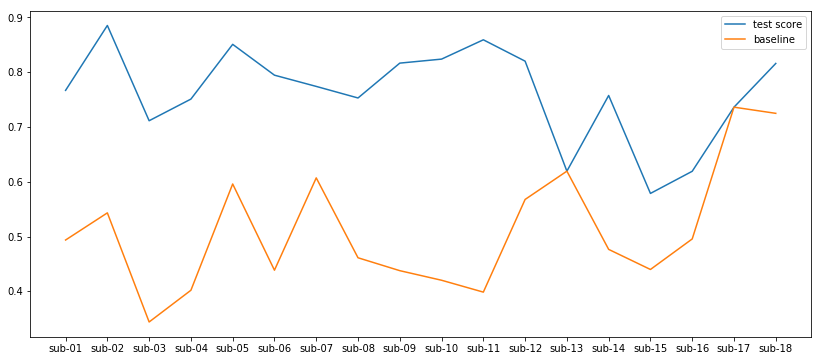

In [31]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(svm_results[['test score']], label = 'test score')
plt.plot(svm_results[['baseline']], label = 'baseline')
plt.legend();

**Result:** Overall, the SVM model using the EEG data as predictors performs better than the baseline for our group of subjects. 

### **2.5 Logistic regression**

In the following cells, we **fine-tune, fit and compute predictions from a logistic regression model**. 

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-5, 5, num = 7)
c_values

array([1.00000000e-05, 4.64158883e-04, 2.15443469e-02, 1.00000000e+00,
       4.64158883e+01, 2.15443469e+03, 1.00000000e+05])

In [34]:
# Create pipeline. 
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Create cross-validation object. 
grid_logreg = {
    'logreg__multi_class': ['multinomial'],
    'logreg__solver': ['saga'],
    'logreg__C': c_values
}
grid_cv_logreg = GridSearchCV(pipe_logreg, grid_logreg, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [35]:
# Run the model. 
logreg_results = classification_with_EEG_predictors(grid_cv_logreg, 'logreg__C')

Starting subject sub-01
Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [36]:
# Display the results. 
logreg_results

,logreg__C,test score,baseline
sub-01,1.000000,0.751543,0.487654
sub-02,46.415888,0.878887,0.518822
sub-03,46.415888,0.728846,0.300000
sub-04,0.021544,0.727660,0.402128
sub-05,1.000000,0.824513,0.618384
sub-06,2154.434690,0.809603,0.460265
sub-07,46.415888,0.787476,0.624288
sub-08,1.000000,0.790123,0.481481
sub-09,1.000000,0.814664,0.474542
sub-10,1.000000,0.789106,0.428771


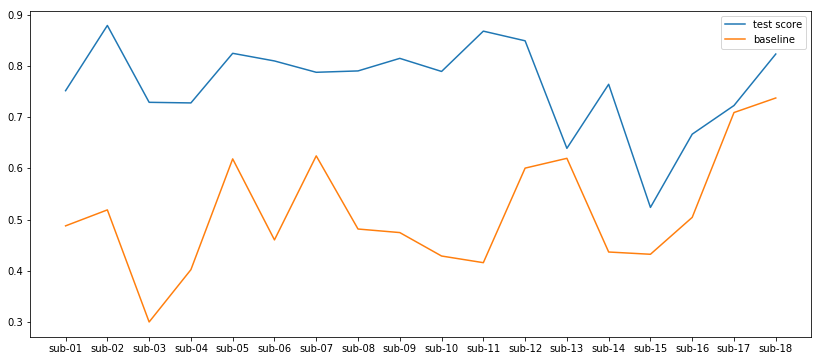

In [37]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(logreg_results[['test score']], label = 'test score')
plt.plot(logreg_results[['baseline']], label = 'baseline')
plt.legend();

**Result:** Overall, the logistic regression model using the EEG data as predictors performs better than the baseline for our group of subjects. 

In [38]:
# Save the results into a .npz file. 
np.savez(results_path + 'classification_with_EEG_predictors.npz', 
         knn_results = knn_results, 
         dt_results = dt_results, 
         rf_results = rf_results, 
         svm_results = svm_results, 
         logreg_results = logreg_results)

## **3. Hypnogram prediction based on fMRI data**

### **3.1 K-Nearest Neighbors (k-NN)**

In the following cells, we **fine-tune, fit and compute predictions from a k-NN model**. 

In [39]:
# Create a new dictionary to store the formatted fMRI data. 
formatted_predictors_fMRI_r3 = dict()

# Iterate through all subjects. 
for subject_index in subjects:

    # Display current step. 
    print('Starting subject ' + subject_index)
    
    # Load the data, and count the number of non-NaN voxels in each 3D image. 
    image_data = predictors_fMRI_r3[subject_index]
    nb_non_nan_voxels = np.sum(~np.isnan(image_data[:, :, :, 0]))
    
    # Retrieve the number of scans, then create a NumPy array with one row per scan and one column per non-NaN voxel. 
    nb_scans = image_data.shape[3]
    formatted_data = np.empty((nb_scans, nb_non_nan_voxels))
    
    # Fill in the array. 
    for scan in range(nb_scans):
        flatten_image = image_data[:, :, :, scan].flatten()
        flatten_image = flatten_image[~np.isnan(flatten_image)]
        formatted_data[scan, :] = flatten_image
        
    # Fill in the dictionary. 
    formatted_predictors_fMRI_r3[subject_index] = formatted_data

Starting subject sub-01
Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [40]:
# Define the set of values to explore, where k is the number of neighbors. 
k_values = np.arange(1, 5, 1)
k_values

array([1, 2, 3, 4])

In [41]:
# Create pipeline. 
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Create cross-validation object. 
grid_knn = {
    'knn__n_neighbors': k_values
}
grid_cv_knn = GridSearchCV(pipe_knn, grid_knn, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [42]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [43]:
# Define a function to run a classification model, taking the fMRI voxel values as features and the hypnogram as target. 
@ignore_warnings(category = ConvergenceWarning)
def classification_with_fMRI_predictors(grid_cv, param_name, formatted_predictors_fMRI):
    
    # Create a Pandas DataFrame to store the results. 
    model_results = pd.DataFrame()

    # Iterate through all subjects. 
    for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 

        # Display current step. 
        print('Starting subject ' + subject_index)

        # Retrieve the predictors, taking the fMRI voxel values as features and the hypnogram as target. 
        X = formatted_predictors_fMRI[subject_index]
        y = predictors_EEG[subject_index].iloc[:, 1].values

        # Divide the data into a train set and a test set. 
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)

        # Create a baseline containing only the most frequent value in the train set. 
        most_frequent_value = np.bincount(y_tr.astype(int)).argmax()
        classification_baseline = np.sum(y_te.astype(int) == most_frequent_value) / y_te.shape[0]

        # Fit the model. 
        grid_cv.fit(X_tr, y_tr)

        # Compute the test score. 
        test_score = grid_cv.score(X_te, y_te)

        # Store the results in the DataFrame. 
        model_results.loc[subject_index, param_name] = grid_cv.best_params_[param_name]
        model_results.loc[subject_index, 'test score'] = test_score
        model_results.loc[subject_index, 'baseline'] = classification_baseline
        
    return model_results

In [44]:
# Run the model. 
knn_results = classification_with_fMRI_predictors(grid_cv_knn, 'knn__n_neighbors', formatted_predictors_fMRI_r3)

Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [45]:
# Display the results. 
knn_results

,knn__n_neighbors,test score,baseline
sub-02,1.0,0.960720,0.527005
sub-03,1.0,0.888462,0.334615
sub-04,1.0,0.851064,0.417021
sub-05,1.0,0.947075,0.601671
sub-06,4.0,0.865894,0.438742
sub-07,1.0,0.920304,0.599620
sub-08,3.0,0.910494,0.418210
sub-09,1.0,0.973523,0.492872
sub-10,1.0,0.938547,0.406425
sub-11,1.0,0.959488,0.383795


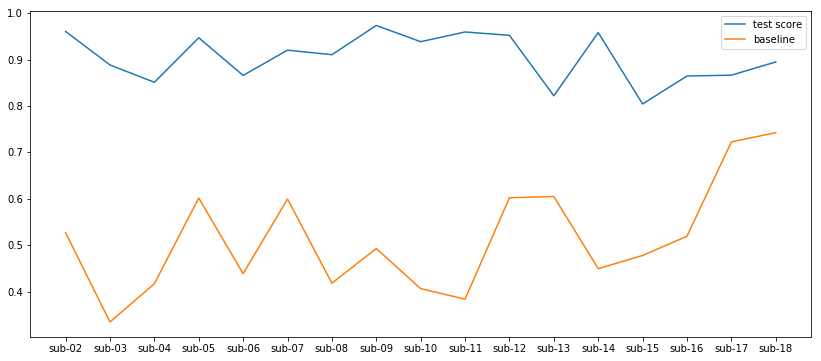

In [46]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(knn_results[['test score']], label = 'test score')
plt.plot(knn_results[['baseline']], label = 'baseline')
plt.legend();

**Result:** Overall, the k-NN model using the fMRI data as predictors performs better than the baseline for our group of subjects. 

### **3.2 Decision tree**

In the following cells, we **fine-tune, fit and compute predictions from a decision tree model**. 

In [47]:
# Define the set of values to explore, where d is the depth of the tree. 
d_values = np.arange(1, 10, 1)
d_values

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [48]:
# Create pipeline. 
pipe_dt = Pipeline([
    ('scaler', None),
    ('dt', DecisionTreeClassifier(criterion = 'gini'))
])

# Create cross-validation object. 
grid_dt = {
    'dt__max_depth': d_values
}
grid_cv_dt = GridSearchCV(pipe_dt, grid_dt, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [49]:
# Run the model. 
dt_results = classification_with_fMRI_predictors(grid_cv_dt, 'dt__max_depth', formatted_predictors_fMRI_r3)

Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [50]:
# Display the results. 
dt_results

,dt__max_depth,test score,baseline
sub-02,3.0,0.932897,0.535188
sub-03,9.0,0.719231,0.328846
sub-04,7.0,0.789362,0.419149
sub-05,8.0,0.864903,0.597493
sub-06,4.0,0.817881,0.455298
sub-07,7.0,0.798861,0.590133
sub-08,4.0,0.848765,0.435185
sub-09,6.0,0.942974,0.443992
sub-10,4.0,0.835196,0.413408
sub-11,7.0,0.848614,0.413646


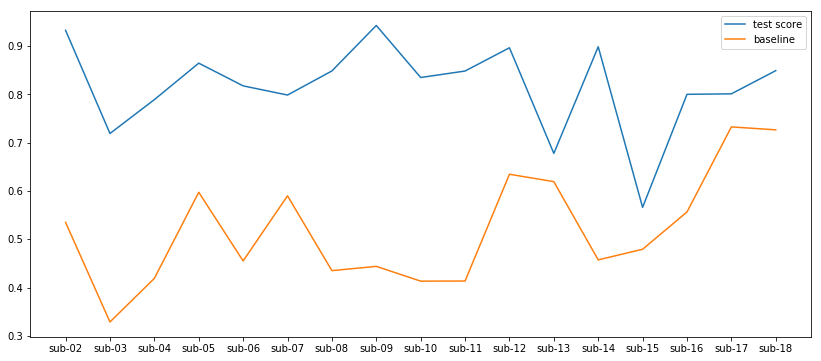

In [51]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(dt_results[['test score']], label = 'test score')
plt.plot(dt_results[['baseline']], label = 'baseline')
plt.legend();

**Result:** Overall, the decision tree model using the fMRI data as predictors performs better than the baseline for our group of subjects. 

### **3.3 Random forest**

In the following cells, we **fine-tune, fit and compute predictions from a random forest model**. 

In [52]:
# Define the set of values to explore, where n is the number of trees. 
n_values = np.arange(5, 55, 5)
n_values

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

In [53]:
# Create pipeline. 
pipe_rf = Pipeline([
    ('scaler', None),
    ('rf', RandomForestClassifier(max_depth = None))
])

# Create cross-validation object. 
grid_rf = {
    'rf__n_estimators': n_values
}
grid_cv_rf = GridSearchCV(pipe_rf, grid_rf, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [54]:
# Run the model. 
rf_results = classification_with_fMRI_predictors(grid_cv_rf, 'rf__n_estimators', formatted_predictors_fMRI_r3)

Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [55]:
# Display the results. 
rf_results

,rf__n_estimators,test score,baseline
sub-02,30.0,0.947627,0.495908
sub-03,40.0,0.813462,0.351923
sub-04,50.0,0.863830,0.417021
sub-05,40.0,0.930362,0.611421
sub-06,20.0,0.857616,0.456954
sub-07,20.0,0.916509,0.567362
sub-08,45.0,0.887346,0.439815
sub-09,50.0,0.961303,0.480652
sub-10,35.0,0.900838,0.388268
sub-11,30.0,0.895522,0.432836


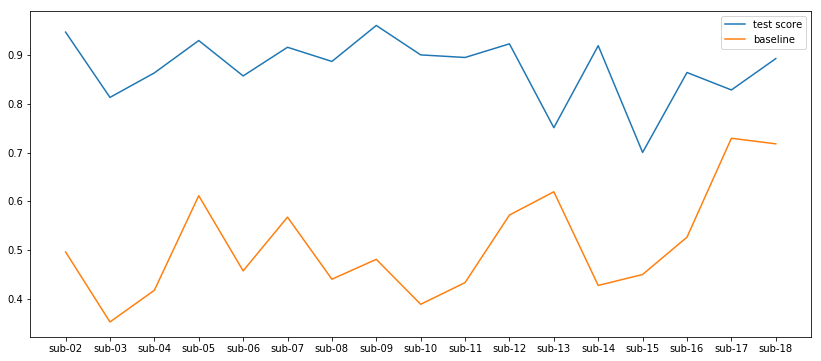

In [56]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(rf_results[['test score']], label = 'test score')
plt.plot(rf_results[['baseline']], label = 'baseline')
plt.legend();

**Result:** Overall, the random forest model using the fMRI data as predictors performs better than the baseline for our group of subjects. 

### **3.4 Support Vector Machine (SVM)**

In the following cells, we **fine-tune, fit and compute predictions from a SVM model**. 

In [57]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-2, 2, num = 7)
c_values

array([1.00000000e-02, 4.64158883e-02, 2.15443469e-01, 1.00000000e+00,
       4.64158883e+00, 2.15443469e+01, 1.00000000e+02])

In [58]:
# Create pipeline. 
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Create cross-validation object. 
grid_svm = {
    'svm__kernel': ['linear'],
    'svm__C': c_values,
    'svm__gamma': ['auto']
}
grid_cv_svm = GridSearchCV(pipe_svm, grid_svm, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [59]:
# Run the model. 
svm_results = classification_with_fMRI_predictors(grid_cv_svm, 'svm__C', formatted_predictors_fMRI_r3)

Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [60]:
# Display the results. 
svm_results

,svm__C,test score,baseline
sub-02,0.046416,0.954173,0.525368
sub-03,0.010000,0.857692,0.321154
sub-04,0.046416,0.889362,0.453191
sub-05,0.046416,0.948468,0.601671
sub-06,0.046416,0.879139,0.433775
sub-07,0.046416,0.924099,0.622391
sub-08,0.010000,0.888889,0.439815
sub-09,0.046416,0.993890,0.494908
sub-10,0.046416,0.928771,0.396648
sub-11,0.010000,0.929638,0.400853


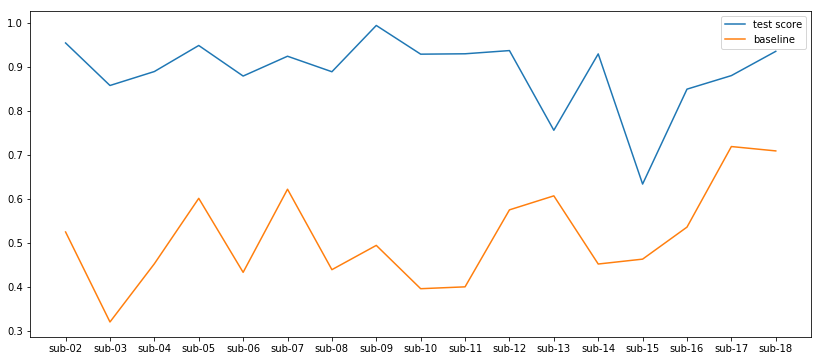

In [61]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(svm_results[['test score']], label = 'test score')
plt.plot(svm_results[['baseline']], label = 'baseline')
plt.legend();

**Result:** Overall, the SVM model using the fMRI data as predictors performs better than the baseline for our group of subjects. 

### **3.5 Logistic regression**

In the following cells, we **fine-tune, fit and compute predictions from a logistic regression model**. 

In [62]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-5, 5, num = 5)
c_values

array([1.00000000e-05, 3.16227766e-03, 1.00000000e+00, 3.16227766e+02,
       1.00000000e+05])

In [63]:
# Create pipeline. 
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Create cross-validation object. 
grid_logreg = {
    'logreg__multi_class': ['multinomial'],
    'logreg__solver': ['saga'],
    'logreg__C': c_values
}
grid_cv_logreg = GridSearchCV(pipe_logreg, grid_logreg, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [64]:
# Run the model. 
logreg_results = classification_with_fMRI_predictors(grid_cv_logreg, 'logreg__C', formatted_predictors_fMRI_r3)

Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [65]:
# Display the results. 
logreg_results

,logreg__C,test score,baseline
sub-02,1.000000,0.942717,0.523732
sub-03,316.227766,0.857692,0.332692
sub-04,1.000000,0.885106,0.382979
sub-05,1.000000,0.948468,0.616992
sub-06,100000.000000,0.879139,0.458609
sub-07,1.000000,0.912713,0.601518
sub-08,1.000000,0.905864,0.435185
sub-09,1.000000,0.973523,0.468432
sub-10,1.000000,0.920391,0.400838
sub-11,316.227766,0.904051,0.402985


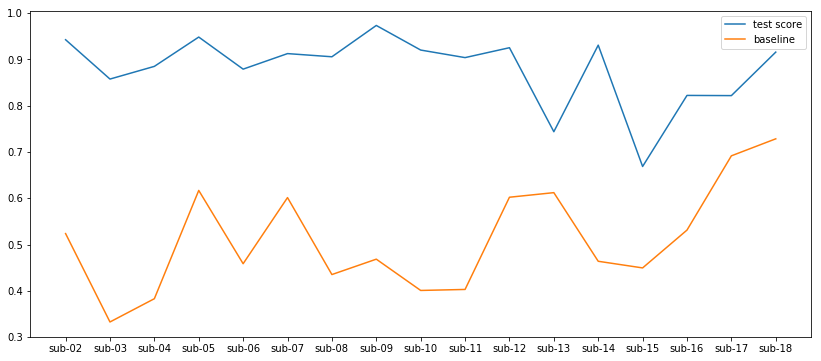

In [66]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(logreg_results[['test score']], label = 'test score')
plt.plot(logreg_results[['baseline']], label = 'baseline')
plt.legend();

**Result:** Overall, the logistic regression model using the fMRI data as predictors performs better than the baseline for our group of subjects. 

In [67]:
# Save the results into a .npz file. 
np.savez(results_path + 'classification_with_fMRI_predictors.npz', 
         knn_results = knn_results, 
         dt_results = dt_results, 
         rf_results = rf_results, 
         svm_results = svm_results, 
         logreg_results = logreg_results)